## Global and individual reports

### General observations 
* As one cold intuitively expect, there is a positive correlation between the number of customers and sales.
    * There are stores that usually receive a much larger number of customers and therefore generate a much higher volume of sales than the average. This is most likely due to their location.
    * One of the goals of commercial strategies should therefore be to optimize the relationship between the number of customers and the volume of sales generated. Ideally, every visitor to a store should become an effective buyer with a relative high expenditure.
    * Another reasonable goal is to increase the number of visitors as much as possible according to the location of the store.
    * In the exploratory data analysis (EDA), we could observe that there are more customers and more sales when a promotion is active (variable Promo in the sales database).
* Some other observations:
    * Stores that are open on Sundays generate high profits, but the ratio of customers to sales is not as high.
    * During the holidays there are generally more customers and sales, especially during Easter vacations and Christmas.

#### Import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_palette("Set2")
%matplotlib inline
warnings.filterwarnings('ignore')

#### Load data

In [2]:
# Combined data for sales and store information
sales_df = pd.read_csv("../data/sales_stores.csv", parse_dates=['Date'])

In [3]:
# weekly aggregated sales data
week_sales_df = pd.read_csv("../data/week_sales.csv")

In [4]:
# error tables for the tested models
avg_errors =  pd.read_csv("../data/avg_errors.csv").drop('Unnamed: 0', axis=1)
pool_reg_errors = pd.read_csv("../data/pool_reg_errors.csv").drop('Unnamed: 0', axis=1)
lr_errors = pd.read_csv("../data/lr_errors.csv").drop('Unnamed: 0', axis=1)
autoreg_errors = pd.read_csv("../data/ar_errors.csv").drop('Unnamed: 0', axis=1)
sarima_errors =pd.read_csv("../data/sarima_errors.csv").drop('Unnamed: 0', axis=1)

In [5]:
# Load predictions
pred_avg = pd.read_csv("../data/pred_avg.csv", parse_dates=['Date']).set_axis(['Store', 'Date', 'Predictions'], axis=1)
pred_pool_reg = pd.read_csv("../data/pred_pool_reg.csv", parse_dates=['Date']).set_axis(['Store', 'Date', 'Predictions'], axis=1)
pred_lr = pd.read_csv("../data/pred_lr.csv", parse_dates=['Date']).set_axis(['Store', 'Date', 'Predictions'], axis=1)
pred_ar = pd.read_csv("../data/pred_ar.csv", parse_dates=['Date']).set_axis(['Store', 'Date', 'Predictions'], axis=1)
pred_sarima = pd.read_csv("../data/pred_sarima.csv", parse_dates=['Date']).set_axis(['Store', 'Date', 'Predictions'], axis=1)

In [6]:
# test data for forecasting models (it is log scaled)
y_test = pd.read_csv("../data/y_test.csv", parse_dates=['Date'])

#### Global analysis without aggregation

We create new features to analyze performance at a global and store level: average daily turnover, average daily number of customers and turnover per customer.

In [7]:
avgs = sales_df.groupby('Store')[['Sales', 'Customers']].mean().reset_index()
avgs.rename({'Sales': 'AvgSales', 'Customers': 'AvgCustomers'}, axis=1, inplace=True)
# This is the same as total sales / total customers
avgs['SalesPerCustomer'] = avgs.apply(lambda x: x['AvgSales'] / x['AvgCustomers'], axis=1)
 
sales_df = sales_df.merge(avgs, on='Store', how='inner')
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,WeekOfYear,...,CompetitionOpenSince,Promo2,Promo2Since,PromoInterval,CompetitionTimeDays,CompetitionTimeMonths,PromoTimeWeeks,AvgSales,AvgCustomers,SalesPerCustomer
0,1,5,2015-07-31,5263,555,1,1,no_holiday,1,31,...,2008-09-01,0,NaN,NaN,2524,82,0,4759.096031,564.049936,8.437366
1,2,5,2015-07-31,6064,625,1,1,no_holiday,1,31,...,2007-11-01,1,2010-03-29,"Jan,Apr,Jul,Oct",2829,93,278,4953.900510,583.998724,8.482725
2,3,5,2015-07-31,8314,821,1,1,no_holiday,1,31,...,2006-12-01,1,2011-04-04,"Jan,Apr,Jul,Oct",3164,104,225,6942.568678,750.077022,9.255808
3,4,5,2015-07-31,13995,1498,1,1,no_holiday,1,31,...,2009-09-01,0,NaN,NaN,2159,70,0,9638.401786,1321.752551,7.292138
4,5,5,2015-07-31,4822,559,1,1,no_holiday,1,31,...,2015-04-01,0,NaN,NaN,121,3,0,4676.274711,537.340180,8.702634


We already took a look at the distributions of `Sales` and `Customers` in our first notebook and noted they both have long tails toward large values. Now we would like to see how the distributions of the variables `AvgSales`, `AvgCustomers` and `Customers` look like:

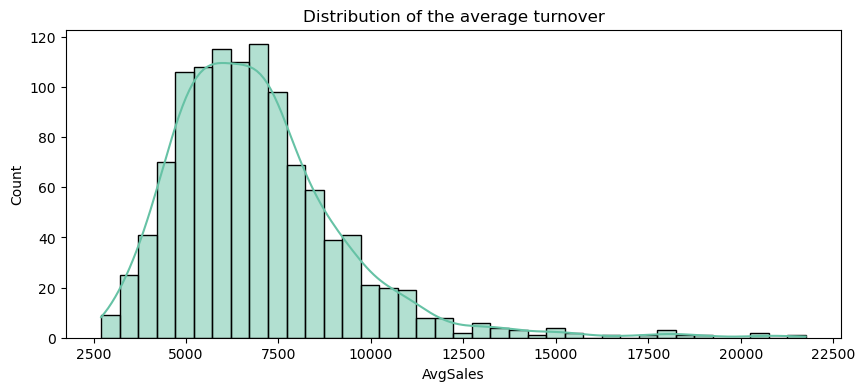

In [8]:
plt.figure(figsize=(10, 4))

sns.histplot(avgs['AvgSales'], kde=True).set(title="Distribution of the average turnover");

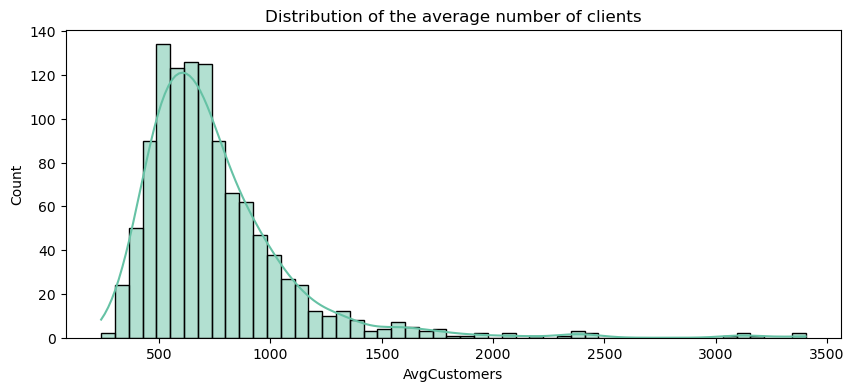

In [9]:
plt.figure(figsize=(10, 4))

sns.histplot(avgs['AvgCustomers'], kde=True).set(title="Distribution of the average number of clients");

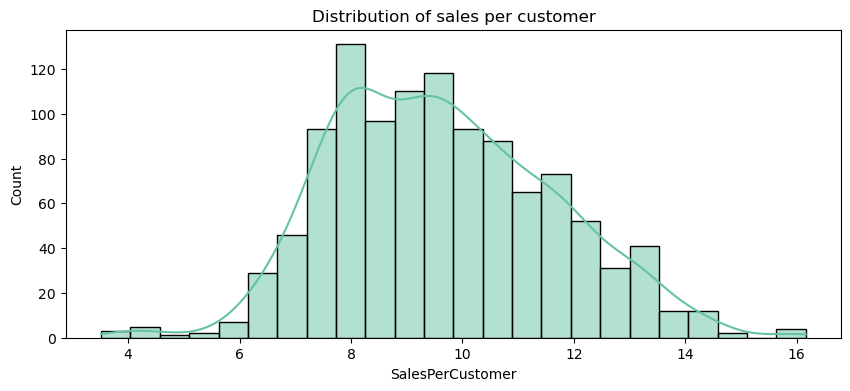

In [10]:
plt.figure(figsize=(10, 4))

sns.histplot(avgs['SalesPerCustomer'], kde=True).set(title="Distribution of sales per customer");

In [11]:
avgs.drop('Store', axis=1).describe()

,AvgSales,AvgCustomers,SalesPerCustomer
count,1115.000000,1115.000000,1115.000000
mean,6934.208449,754.510158,9.643756
std,2383.911051,353.344414,1.986858
min,2703.736573,240.183099,3.513703
25%,5322.299969,541.468688,8.131856
50%,6589.948470,678.667519,9.464061
75%,7964.200644,866.203304,10.981168
max,21757.483418,3403.458599,16.162639


`AvgSales` and `AvgCustomers` have a long-tail distribution, just like `Sales` and `Customers`.

#### Individual reports

##### Summary statistics per store

In [12]:
def display_store_statistics(store):
    '''
    Display statistics for a given store in comparison to the global values.
    Args:
        store (int): The id of the store
    '''
    store_mask = avgs['Store'] == store
    stats_df = avgs[store_mask]
    stats_df['GlobalAvgSales'] = avgs['AvgSales'].mean()
    stats_df['GlobalAvgCustomers'] = avgs['AvgCustomers'].mean()
    stats_df['GlobalSalesPerCustomer'] = avgs['SalesPerCustomer'].mean()
    store_mask_1 = sales_df['Store'] == store
    stats_df['DaysOpen'] = sales_df[store_mask_1]['Open'].sum()
    #stats_df = stats_df.iloc[:, [0, 3, 1, 4, 2, 5]]
    stats_df = stats_df[['DaysOpen', 'AvgSales', 'GlobalAvgSales', 'AvgCustomers', 'GlobalAvgCustomers',
                        'SalesPerCustomer', 'GlobalSalesPerCustomer']]
    print(f"Statistics for store number {store}:")
    display(stats_df)

In [13]:
# Usage example for store number 1
display_store_statistics(1)

Statistics for store number 1:


,DaysOpen,AvgSales,GlobalAvgSales,AvgCustomers,GlobalAvgCustomers,SalesPerCustomer,GlobalSalesPerCustomer
0,781,4759.096031,6934.208449,564.049936,754.510158,8.437366,9.643756


##### Sales, sustomers and sales per customer distribution per store

In [14]:
def draw_sales_and_customers_dists(store):
    '''
    Draw sales, customers and sales per customer histograms for a given store 
    separated by presence or absence from promo.
    Args:
        store (int): The id of the store
    '''
    store_mask = sales_df['Store'] == store
    store_df = sales_df[store_mask]
    # draw distributions
    plt.figure(figsize=(10, 4))
    without_promo_mask = store_df['Promo'] == 0
    with_promo_mask = store_df['Promo'] == 1
    # sales
    plt.subplot(1, 3, 1)
    sns.histplot(x = store_df['Sales'][without_promo_mask], kde=True)
    sns.histplot(x = store_df['Sales'][with_promo_mask], kde=True)
    plt.legend(labels = ['Without Promo', 'With Promo'], loc = 'upper right')
    # customers
    plt.subplot(1, 3, 2)
    sns.histplot(x = store_df['Customers'][without_promo_mask], kde=True)
    sns.histplot(x = store_df['Customers'][with_promo_mask], kde=True)
    plt.legend(labels = ['Without Promo', 'With Promo'], loc = 'upper right')
    # sales per customer
    plt.subplot(1, 3, 3)
    sns.histplot(x = store_df['Sales'][without_promo_mask] / store_df['Customers'][without_promo_mask], kde=True)
    sns.histplot(x = store_df['Sales'][with_promo_mask] / store_df['Customers'][with_promo_mask], kde=True).set(xlabel='Sales per Customer')
    plt.legend(labels = ['Without Promo', 'With Promo'], loc = 'upper right')
    plt.suptitle(f"Sales, customers and sales per customer distribution for store {store}")
    plt.tight_layout();
    pass

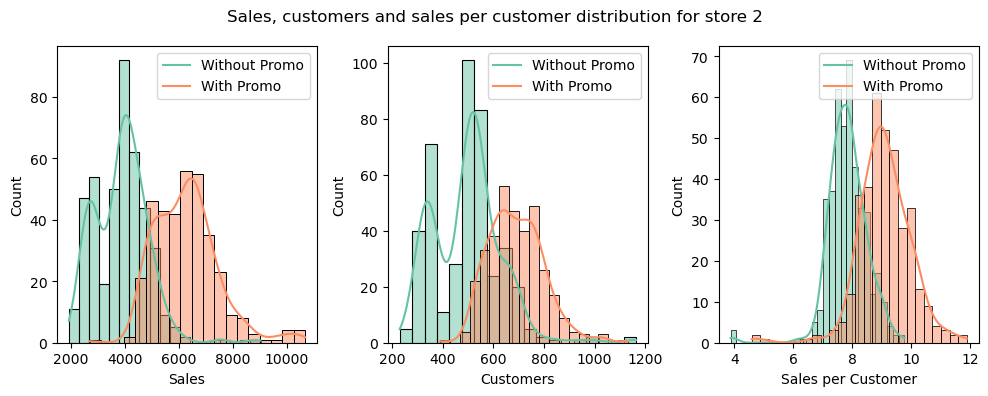

In [15]:
# Usage example for store number 2
draw_sales_and_customers_dists(2)

### Sales forecasting

Let's see a comparison of the performance of the models with which we have experimented so far:

In [16]:
pd.concat([avg_errors, pool_reg_errors, lr_errors, autoreg_errors, sarima_errors]).set_index('Model Name')

,MAE,MAPE,RMSE
Model Name,,,
Averages Model,4218.377087,0.108220,5810.060655
Pooled Regression with OLS,3177.766337,0.079115,4429.824986
Linear Regression per Store,3051.338616,0.077325,4424.518507
"AR(1,2,3,5,52,53)",4141.852461,0.112542,6455.862889
"SARIMA(0,1,1)(1,0,0)[52]A",3737.105358,0.100979,6007.010634


As we can see in the table above, so far the best model we have found is that which consists of individual linear regressions per store.

In [17]:
def get_predictions(store, model="linear regression per store"):
    '''
    Creates a Pandas dataframe with the sales forecasts compared to actual values for a given store
    and regression model.
    Args:
        store (int): The id of the store
        model (string): Model used for the regression. Possible values are 
        "averages", "pooled regression", "linear regression per store", "autoregressive model" and "sarima".
        The deafault model if one is not explicity given is "linear regression per store".
    '''
    
    pred_dict = {
        "averages" : pred_avg,
        "pooled regression" : pred_pool_reg,
        "linear regression per store" : pred_lr,
        "autoregressive model" : pred_ar,
        "sarima" : pred_sarima
    }
    # predictions
    pred_df = pred_dict.get(model)
    store_mask = pred_df['Store'] == store
    predictions = pred_df[store_mask].drop('Store', axis=1).set_index('Date').sort_index()
    # actual values
    actual = y_test[store_mask].drop('Store', axis=1).set_index('Date').sort_index().set_axis(['Actual'], axis=1)
    actual = np.expm1(actual)
    predictions = predictions.join(actual)
    # display results
    print(f"Predictions for store number {store} (model = {model}):")
    pd.options.display.float_format = "{:,.2f}".format
    display(predictions)
    return predictions

Usage example with default model (linear regression per store):

In [18]:
predictions = get_predictions(1)

Predictions for store number 1 (model = linear regression per store):


,Predictions,Actual
Date,,
2015-06-08,"24,814.98","24,789.00"
2015-06-15,"28,261.42","25,642.00"
2015-06-22,"24,710.78","23,174.00"
2015-06-29,"28,192.19","30,337.00"
2015-07-06,"24,694.45","23,736.00"
2015-07-13,"28,224.33","27,889.00"
2015-07-20,"24,595.35","24,963.00"
2015-07-27,"24,254.69","20,076.00"


Usage example with the SARIMA model

In [19]:
predictions = get_predictions(1, "sarima")

Predictions for store number 1 (model = sarima):


,Predictions,Actual
Date,,
2015-06-08,"25,072.73","24,789.00"
2015-06-15,"24,469.32","25,642.00"
2015-06-22,"24,194.39","23,174.00"
2015-06-29,"26,858.10","30,337.00"
2015-07-06,"24,292.44","23,736.00"
2015-07-13,"26,947.78","27,889.00"
2015-07-20,"24,227.82","24,963.00"
2015-07-27,"28,790.43","20,076.00"
